IMPORTS AND SETUP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Libraries imported!")

✅ Libraries imported!


DATA LOADING AND INITIAL CLEANING

In [2]:
# Load the dataset
df = pd.read_csv('salaries.csv')
print(f"✅ Dataset loaded successfully! Shape: {df.shape}")

# Remove duplicates
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"🧹 Removed {initial_rows - df.shape[0]} duplicate rows")
print(f"Final shape: {df.shape}")

# Basic data exploration
print("\n📊 Dataset Overview:")
print(f"Columns: {list(df.columns)}")
print(f"Missing values:\n{df.isnull().sum()}")

✅ Dataset loaded successfully! Shape: (16494, 11)
🧹 Removed 6401 duplicate rows
Final shape: (10093, 11)

📊 Dataset Overview:
Columns: ['work_year', 'experience_level', 'employment_type', 'job_title', 'salary', 'salary_currency', 'salary_in_usd', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']
Missing values:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


BASIC FEATURE ENGINEERING (No Target Dependencies)

1. Create remote work type from remote_ratio

In [3]:
print(" Creating basic features (no target dependencies)...")
if 'remote_ratio' in df.columns:
    df['remote_work_type'] = df['remote_ratio'].apply(
        lambda x: 'Remote' if x == 1 else ('Hybrid' if x == 0.5 else 'On-site')
    )

 Creating basic features (no target dependencies)...


2. Focused job title categorization (core ML/AI roles only)

In [4]:
def categorize_job_title_advanced(title):
    """Focused job title categorization for core ML/AI roles"""
    title = str(title).lower()

    # Core ML/AI roles (based on Hiring Cafe focus)
    if any(word in title for word in ['data scientist', 'senior data scientist', 'lead data scientist', 'principal data scientist']):
        return 'Data_Scientist'
    elif any(word in title for word in ['machine learning engineer', 'ml engineer', 'ml/ai engineer', 'mle']):
        return 'ML_Engineer'
    elif any(word in title for word in ['ai engineer', 'artificial intelligence engineer', 'ai/ml engineer']):
        return 'AI_Engineer'
    elif any(word in title for word in ['data engineer', 'etl engineer', 'big data engineer', 'data infrastructure engineer']):
        return 'Data_Engineer'
    elif any(word in title for word in ['data analyst', 'business analyst', 'analytics engineer', 'data analytics']):
        return 'Data_Analyst'

    # All other roles (including research, software, devops, management, etc.)
    else:
        return 'Other_Roles'

df['job_title_category'] = df['job_title'].apply(categorize_job_title_advanced)

3. Country extraction (no target dependencies)

In [5]:
def extract_country(location):
    """Extract country from location string"""
    if pd.isna(location):
        return 'Unknown'

    location = str(location).strip()

    # Common country patterns
    if location in ['US', 'United States', 'USA']:
        return 'United_States'
    elif location in ['CA', 'Canada']:
        return 'Canada'
    elif location in ['GB', 'United Kingdom', 'UK']:
        return 'United_Kingdom'
    elif location in ['AU', 'Australia']:
        return 'Australia'
    elif location in ['DE', 'Germany']:
        return 'Germany'
    elif location in ['FR', 'France']:
        return 'France'
    elif location in ['NL', 'Netherlands']:
        return 'Netherlands'
    elif location in ['IN', 'India']:
        return 'India'
    elif location in ['BR', 'Brazil']:
        return 'Brazil'
    elif location in ['ES', 'Spain']:
        return 'Spain'
    elif location in ['IT', 'Italy']:
        return 'Italy'
    elif location in ['SE', 'Sweden']:
        return 'Sweden'
    elif location in ['CH', 'Switzerland']:
        return 'Switzerland'
    elif location in ['JP', 'Japan']:
        return 'Japan'
    elif location in ['SG', 'Singapore']:
        return 'Singapore'
    else:
        return 'Other_Countries'

df['country'] = df['company_location'].apply(extract_country)

4. Ordinal encodings (no target dependencies)

In [6]:
experience_mapping = {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
size_mapping = {'S': 1, 'M': 2, 'L': 3}
employment_mapping = {'FT': 1, 'PT': 0.5, 'CT': 0.8, 'FL': 0.7}

df['experience_level_encoded'] = df['experience_level'].map(experience_mapping)
df['company_size_encoded'] = df['company_size'].map(size_mapping)
df['employment_type_encoded'] = df['employment_type'].map(employment_mapping)

5. Interaction features (no target dependencies)

In [7]:
df['exp_size_interaction'] = df['experience_level_encoded'] * df['company_size_encoded']
df['exp_remote_interaction'] = df['experience_level_encoded'] * (df['remote_ratio'] if 'remote_ratio' in df.columns else 0)
df['size_remote_interaction'] = df['company_size_encoded'] * (df['remote_ratio'] if 'remote_ratio' in df.columns else 0)


6. Job title complexity (no target dependencies)

In [8]:
df['job_title_complexity'] = df['job_title'].str.split().str.len()

7. Location diversity (no target dependencies)

In [9]:
location_counts = df.groupby('job_title')['company_location'].nunique()
df['location_diversity'] = df['job_title'].map(location_counts)

print("✅ Basic features created (no target dependencies)")

✅ Basic features created (no target dependencies)


DATA SPLITTING

In [10]:
print("🔍 Splitting data BEFORE creating target-dependent features...")

# Prepare features and target
feature_columns = [col for col in df.columns if col not in ['salary', 'salary_currency', 'remote_ratio', 'salary_in_usd']]
X = df[feature_columns]
y = df['salary_in_usd']

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

# CRITICAL: Split data FIRST, before any target-dependent feature engineering
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Data split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

🔍 Splitting data BEFORE creating target-dependent features...
Feature matrix shape: (10093, 18)
Target shape: (10093,)
✅ Data split completed:
Training set: 8074 samples
Testing set: 2019 samples


TARGET-DEPENDENT FEATURE ENGINEERING

In [11]:
print("🔧 Keeping only legitimate features (no target dependencies)...")

# Create training data DataFrame for feature engineering
train_df = X_train.copy()
train_df['salary_in_usd'] = y_train

# REMOVED: All target-dependent features to eliminate data leakage
print("⚠️  REMOVING target-dependent features to eliminate data leakage...")

# Only keep legitimate features that don't use the target variable
print("Keeping only domain knowledge and interaction features...")

print("\n✅ LEGITIMATE FEATURES (KEEPING):")
print("- Job title categorization (5 core ML/AI roles + other)")
print("- Country extraction (geographic patterns)")
print("- Experience level encoding (ordinal)")
print("- Company size encoding (ordinal)")
print("- Employment type encoding (ordinal)")
print("- Interaction features (exp × size, exp × remote, size × remote)")
print("- Job title complexity (word count)")
print("- Location diversity (unique locations per job title)")

print("\n🚨 REMOVED FEATURES (DATA LEAKAGE):")
print("- salary_percentile_by_title (uses target variable)")
print("- job_title_mean_salary (uses target variable)")
print("- exp_level_mean_salary (uses target variable)")
print("- company_size_mean_salary (uses target variable)")
print("- remote_premium (uses target variable)")
print("- country_salary_premium (uses target variable)")
print("- All salary statistics by groups (use target variable)")

print("\nNote: We're not creating any salary statistics, premiums, or percentiles")
print("as these all use the target variable and cause data leakage")

# No statistics to merge - we're keeping only legitimate features
print("✅ Training data ready with only legitimate features (no target dependencies)")

print("✅ Only legitimate features kept (no target dependencies)")



🔧 Keeping only legitimate features (no target dependencies)...
⚠️  REMOVING target-dependent features to eliminate data leakage...
Keeping only domain knowledge and interaction features...

✅ LEGITIMATE FEATURES (KEEPING):
- Job title categorization (5 core ML/AI roles + other)
- Country extraction (geographic patterns)
- Experience level encoding (ordinal)
- Company size encoding (ordinal)
- Employment type encoding (ordinal)
- Interaction features (exp × size, exp × remote, size × remote)
- Job title complexity (word count)
- Location diversity (unique locations per job title)

🚨 REMOVED FEATURES (DATA LEAKAGE):
- salary_percentile_by_title (uses target variable)
- job_title_mean_salary (uses target variable)
- exp_level_mean_salary (uses target variable)
- company_size_mean_salary (uses target variable)
- remote_premium (uses target variable)
- country_salary_premium (uses target variable)
- All salary statistics by groups (use target variable)

Note: We're not creating any salary s

TEST DATA PREPARATION

In [12]:
print("Test data ready (no target-dependent features to apply)...")

# Test data already has all the legitimate features from the initial feature engineering
# No additional target-dependent features to add
print("✅ Test data ready with only legitimate features (no target dependencies)")

Test data ready (no target-dependent features to apply)...
✅ Test data ready with only legitimate features (no target dependencies)


FEATURE PREPROCESSING

In [13]:
print("🔧 Preprocessing features...")

# Identify categorical columns FIRST
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns: {categorical_columns}")

# Apply one-hot encoding to categorical columns BEFORE handling missing values
if categorical_columns:
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

    # Ensure both datasets have the same columns
    missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
    for col in missing_cols:
        X_test_encoded[col] = 0

    # Reorder test columns to match training
    X_test_encoded = X_test_encoded[X_train_encoded.columns]

    print(f"After encoding:")
    print(f"Training: {X_train_encoded.shape}")
    print(f"Testing: {X_test_encoded.shape}")
else:
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

# NOW handle missing values AFTER encoding (all columns are numeric)
X_train_encoded = X_train_encoded.fillna(X_train_encoded.median())
X_test_encoded = X_test_encoded.fillna(X_test_encoded.median())

print(f"Missing values after filling:")
print(f"Training: {X_train_encoded.isnull().sum().sum()}")
print(f"Testing: {X_test_encoded.isnull().sum().sum()}")

# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print("✅ Feature preprocessing completed!")


🔧 Preprocessing features...
Categorical columns: ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size', 'remote_work_type', 'job_title_category', 'country']
After encoding:
Training: (8074, 341)
Testing: (2019, 341)
Missing values after filling:
Training: 0
Testing: 0
✅ Feature preprocessing completed!


MODEL TRAINING AND EVALUATION

In [14]:
print("🤖 Training models with corrected feature engineering...")

# Define models to test
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"Training {name}...")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

    print(f"  {name} - MAE: ${mae:,.2f}, RMSE: ${rmse:,.2f}, R²: {r2:.4f}")

# Display results in a table
results_df = pd.DataFrame(results).T
print("\n📋 Model Performance Summary (Corrected - No Data Leakage):")
print(results_df.round(4))

🤖 Training models with corrected feature engineering...
Training Random Forest...
  Random Forest - MAE: $44,924.82, RMSE: $65,881.33, R²: 0.2623
Training XGBoost...
  XGBoost - MAE: $44,110.51, RMSE: $65,191.32, R²: 0.2777
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 8074, number of used features: 85
[LightGBM] [Info] Start training from score 146841.711791
  LightGBM - MAE: $44,323.68, RMSE: $64,868.74, R²: 0.2848

📋 Model Performance Summary (Corrected - No Data Leakage):
                      MAE           MSE        RMSE      R²
Random Forest  44924.8153  4.340350e+09  65881.3301  0.2623
XGBoost        44110.5117  4.249909e+09  65191.3241  0.2777
LightGBM       44323.6841  4.207953e+09  64868.

FEATURE IMPORTANCE ANALYSIS

📊 Analyzing feature importance...

🔝 Top 15 Most Important Features:
                                  feature  importance
1                experience_level_encoded    0.240705
241                 employee_residence_US    0.145633
57                 job_title_Data Analyst    0.072401
0                               work_year    0.068808
8                      location_diversity    0.037552
324        job_title_category_ML_Engineer    0.030648
6                 size_remote_interaction    0.024561
4                    exp_size_interaction    0.023208
5                  exp_remote_interaction    0.021266
173                 employee_residence_CA    0.019109
157          job_title_Research Scientist    0.018863
31            job_title_Applied Scientist    0.013546
7                    job_title_complexity    0.011355
138  job_title_Machine Learning Scientist    0.010548
321       job_title_category_Data_Analyst    0.008947


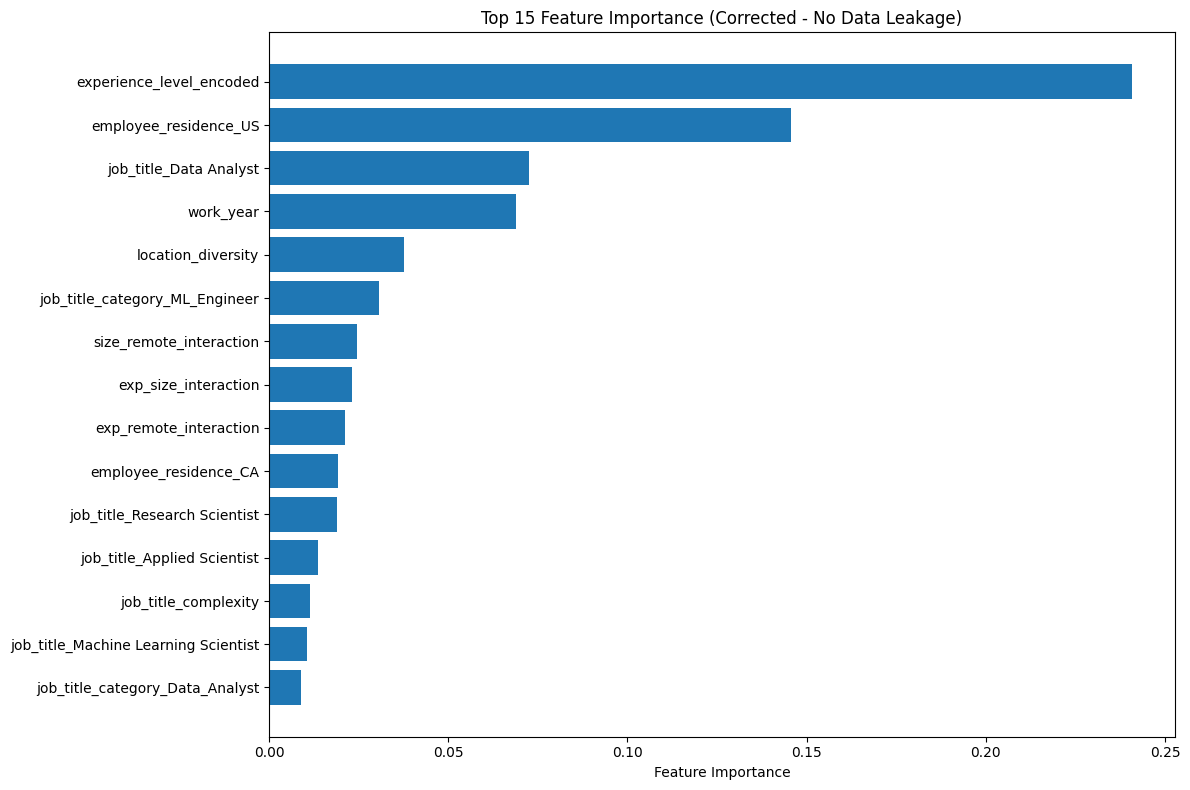

In [15]:
print("📊 Analyzing feature importance...")

# Use Random Forest to get feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 Top 15 Most Important Features:")
print(feature_importance.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importance (Corrected - No Data Leakage)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

DEEP LEARNING MODEL

In [16]:
print("🧠 Training Deep Learning model...")

def create_advanced_nn(input_dim):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_dim=input_dim),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Create and train the model
dl_model = create_advanced_nn(X_train_scaled.shape[1])

# Callbacks
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=10, min_lr=1e-6)

# Train the model
history = dl_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the deep learning model
y_pred_dl = dl_model.predict(X_test_scaled).flatten()

dl_mae = mean_absolute_error(y_test, y_pred_dl)
dl_mse = mean_squared_error(y_test, y_pred_dl)
dl_rmse = np.sqrt(dl_mse)
dl_r2 = r2_score(y_test, y_pred_dl)

print(f"\n🧠 Deep Learning Results (Corrected - No Data Leakage):")
print(f"MAE: ${dl_mae:,.2f}")
print(f"RMSE: ${dl_rmse:,.2f}")
print(f"R²: {dl_r2:.4f}")

🧠 Training Deep Learning model...
Epoch 1/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 26458800128.0000 - mae: 146028.5312 - val_loss: 28639336448.0000 - val_mae: 151106.9062 - learning_rate: 0.0010
Epoch 2/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 26456303616.0000 - mae: 146023.7812 - val_loss: 28634384384.0000 - val_mae: 151095.7031 - learning_rate: 0.0010
Epoch 3/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 26451736576.0000 - mae: 146013.2812 - val_loss: 28627865600.0000 - val_mae: 151080.9219 - learning_rate: 0.0010
Epoch 4/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 26444800000.0000 - mae: 145996.8750 - val_loss: 28619147264.0000 - val_mae: 151062.5312 - learning_rate: 0.0010
Epoch 5/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 26435674112.0000 - mae: 145974.1719 - val_loss: 28610004992.0000 - val_mae: 151040.2500 - learning_rate: 0.0010
Epoch 6/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 26424793088.0000 - mae: 145946.8906 

FINAL MODEL COMPARISON

📈 Comparing all models (Corrected - No Data Leakage)...
🏆 Best Model: LightGBM


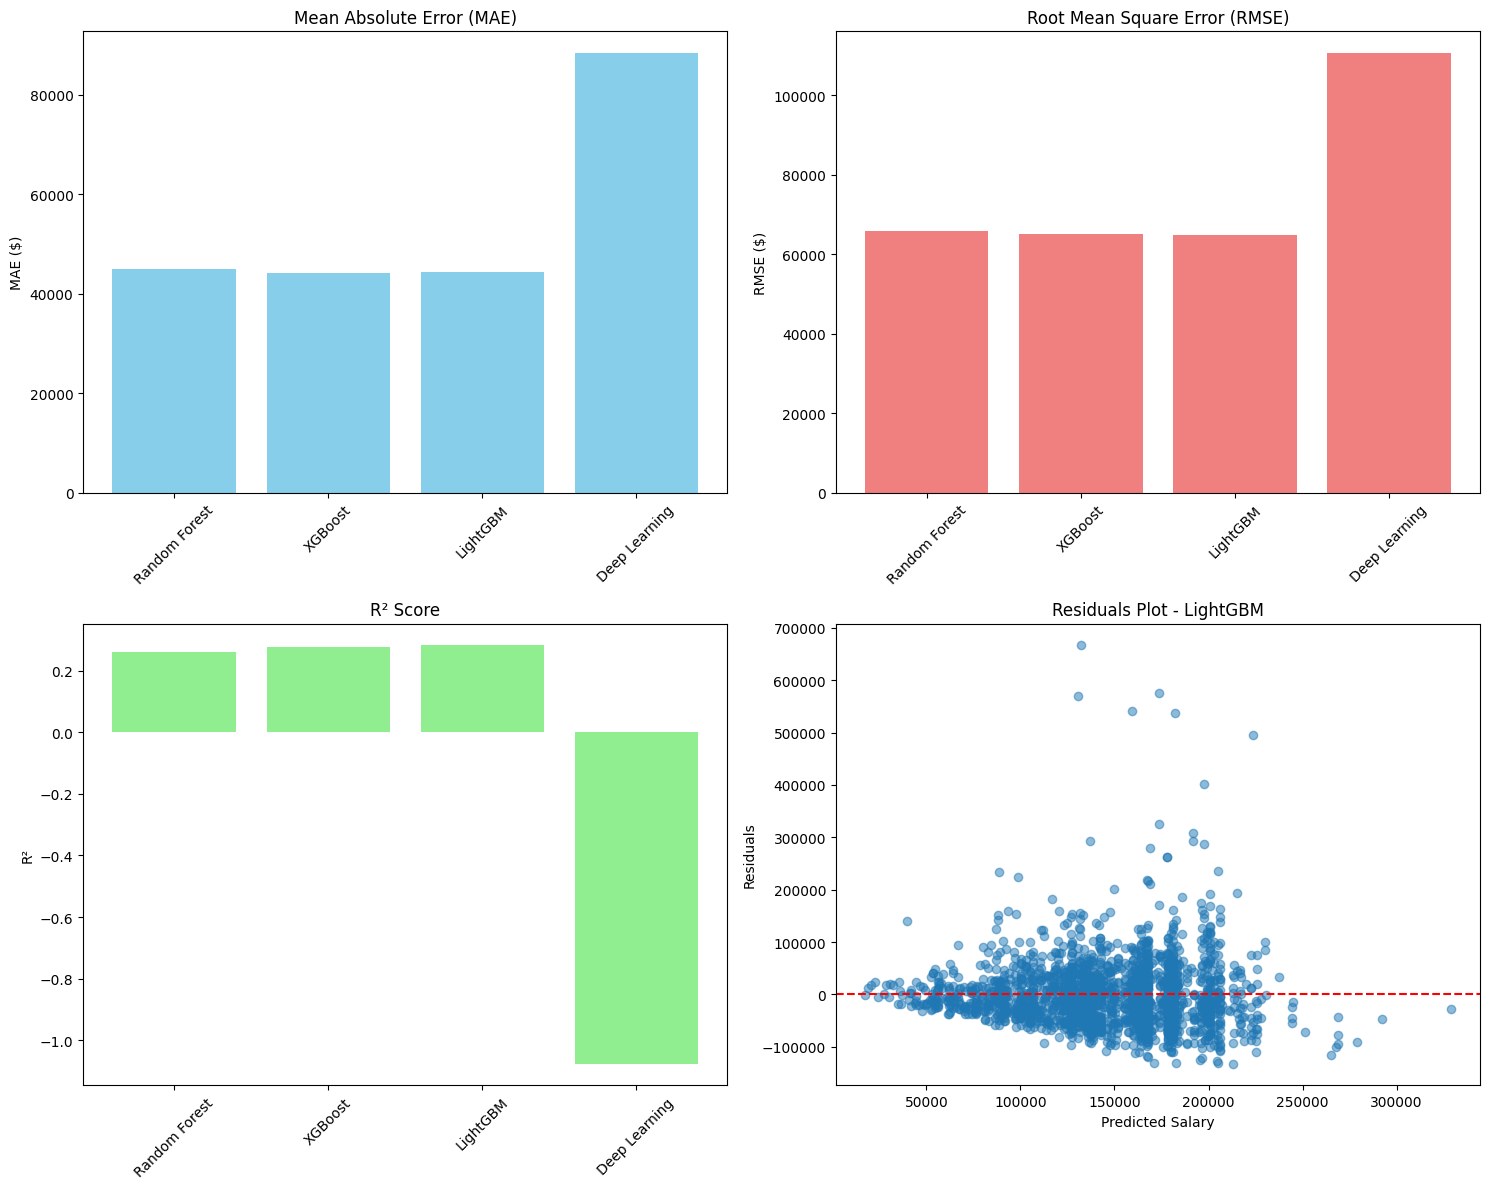


🎉 Analysis Complete (Corrected - No Data Leakage)!
Best R² Score: 0.2848
Best MAE: $44,323.68
Best RMSE: $64,868.74


In [17]:
print("📈 Comparing all models (Corrected - No Data Leakage)...")

# Add deep learning to results
results['Deep Learning'] = {
    'MAE': dl_mae,
    'MSE': dl_mse,
    'RMSE': dl_rmse,
    'R²': dl_r2
}

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['R²'])
print(f"🏆 Best Model: {best_model_name}")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# MAE Comparison
mae_values = [results[model]['MAE'] for model in results.keys()]
axes[0, 0].bar(results.keys(), mae_values, color='skyblue')
axes[0, 0].set_title('Mean Absolute Error (MAE)')
axes[0, 0].set_ylabel('MAE ($)')
axes[0, 0].tick_params(axis='x', rotation=45)

# RMSE Comparison
rmse_values = [results[model]['RMSE'] for model in results.keys()]
axes[0, 1].bar(results.keys(), rmse_values, color='lightcoral')
axes[0, 1].set_title('Root Mean Square Error (RMSE)')
axes[0, 1].set_ylabel('RMSE ($)')
axes[0, 1].tick_params(axis='x', rotation=45)

# R² Comparison
r2_values = [results[model]['R²'] for model in results.keys()]
axes[1, 0].bar(results.keys(), r2_values, color='lightgreen')
axes[1, 0].set_title('R² Score')
axes[1, 0].set_ylabel('R²')
axes[1, 0].tick_params(axis='x', rotation=45)

# Residuals plot for best model
if best_model_name == 'Deep Learning':
    y_pred_best = y_pred_dl
else:
    best_model = models[best_model_name]
    y_pred_best = best_model.predict(X_test_scaled)

residuals = y_test - y_pred_best
axes[1, 1].scatter(y_pred_best, residuals, alpha=0.5)
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Predicted Salary')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title(f'Residuals Plot - {best_model_name}')

plt.tight_layout()
plt.show()

print(f"\n🎉 Analysis Complete (Corrected - No Data Leakage)!")
print(f"Best R² Score: {results[best_model_name]['R²']:.4f}")
print(f"Best MAE: ${results[best_model_name]['MAE']:,.2f}")
print(f"Best RMSE: ${results[best_model_name]['RMSE']:,.2f}")

In [19]:
import joblib
import json
import pickle

# Replace these with the actual variables you used in Model 5
final_model = models['LightGBM']          # your trained model
scaler_used = scaler           # the scaler you applied to inputs
feature_names = X_train_encoded.columns.tolist()  # or wherever your feature names come from

# Save the model
joblib.dump(final_model, "best_model.pkl")
print("✅ best_model.pkl saved")

# Save the scaler
joblib.dump(scaler_used, "scaler.pkl")
print("✅ scaler.pkl saved")

# Save feature names
with open("feature_names.json", "w") as f:
    json.dump(feature_names, f)
print("✅ feature_names.json saved")

# Save deployment functions or metadata if needed
deployment_data = {"feature_names": feature_names}
with open("deployment_functions.pkl", "wb") as f:
    pickle.dump(deployment_data, f)
print("✅ deployment_functions.pkl saved")

✅ best_model.pkl saved
✅ scaler.pkl saved
✅ feature_names.json saved
✅ deployment_functions.pkl saved


Deployment Application

In [ ]:
# MLPayGrade Hugging Face Spaces Deployment
# This file will be automatically deployed on Hugging Face Spaces

import gradio as gr
import joblib
import json
import pickle
import pandas as pd
import numpy as np
import os

# Load model components
def load_model():
    """Load all saved model components"""
    try:
        # Load model and scaler
        model = joblib.load('best_model.pkl')
        scaler = joblib.load('scaler.pkl')

        # Load feature names
        with open('feature_names.json', 'r') as f:
            feature_names = json.load(f)

        # Load deployment functions
        with open('deployment_functions.pkl', 'rb') as f:
            deployment_data = pickle.load(f)

        return model, scaler, feature_names, deployment_data
    except Exception as e:
        print(f"Error loading model components: {e}")
        return None, None, None, None

def engineer_features_simple(job_title, experience_level, company_size, employment_type, company_location, remote_ratio):
    """Simple feature engineering without complex dependencies"""

    # Basic mappings
    exp_mapping = {"EN": 1, "MI": 2, "SE": 3, "EX": 4}
    size_mapping = {"S": 1, "M": 2, "L": 3}
    emp_mapping = {"FT": 1, "PT": 0.5, "CT": 0.8, "FL": 0.7}

    # Create features
    features = {}

    # Update with feature engineering
    features['work_year'] = 2024 # Current year
    features['remote_ratio'] = remote_ratio
    features['experience_level'] = exp_mapping.get(experience_level, 0)
    features['company_size'] = size_mapping.get(company_size, 0)
    features['employment_type'] = emp_mapping.get(employment_type, 0)

    # One-hot encoding for job title and company location
    # Ensure deployment_data is loaded before accessing it
    model, scaler, feature_names, deployment_data = load_model() # Reloading to ensure deployment_data is available

    if deployment_data and 'feature_names' in deployment_data:
        # Extract one-hot encoded columns from feature_names
        # Use the first 5 job title categories from the training data as options
        jt_category_cols = [col for col in deployment_data['feature_names'] if col.startswith('job_title_category_')]
        # Extract the category name from the column name
        jt_category_names = [col.replace('job_title_category_', '') for col in jt_category_cols]

        cl_cols = [col for col in deployment_data['feature_names'] if col.startswith('country_')]
        # Extract the country name from the column name
        cl_names = [col.replace('country_', '') for col in cl_cols]


        # One-hot encode job title
        if job_title:
            # Check if the selected job title is one of the categorized roles
            if job_title in jt_category_names:
                 jt_key = 'job_title_category_' + job_title
                 if jt_key in deployment_data['feature_names']:
                     features[jt_key] = 1
            else:
                 # If not one of the categories, it's 'Other_Roles'
                 jt_key = 'job_title_category_Other_Roles'
                 if jt_key in deployment_data['feature_names']:
                     features[jt_key] = 1

        # One-hot encode company location
        if company_location:
            cl_key = 'country_' + company_location.replace(" ", "_").replace("/", "_")
            if cl_key in deployment_data['feature_names']:
                features[cl_key] = 1
            # Handle 'Other_Countries' if the location is not in the training data
            else:
                cl_key = 'country_Other_Countries'
                if cl_key in deployment_data['feature_names']:
                    features[cl_key] = 1


    # Pad features with zeros for missing one-hot encoded features
    if deployment_data and 'feature_names' in deployment_data:
        for col in deployment_data['feature_names']:
            if col not in features:
                features[col] = 0

    # Ensure all feature names from training are present, even if 0
    full_features = {name: features.get(name, 0) for name in deployment_data['feature_names']}

    return full_features


# The main prediction function
def predict_salary(job_title, experience_level, company_size, employment_type, company_location, remote_ratio):
    try:
        # Get model components
        model, scaler, feature_names, deployment_data = load_model()

        # Check if components loaded
        if model is None or scaler is None or feature_names is None or deployment_data is None:
            return "Error: Model components could not be loaded."

        # Engineer features
        input_features = engineer_features_simple(job_title, experience_level, company_size, employment_type, company_location, remote_ratio)

        # Create DataFrame
        df = pd.DataFrame([input_features])
        # Ensure correct order of features based on the training data
        df = df[feature_names]

        # Scale features
        scaled_features = scaler.transform(df)

        # Make prediction
        predicted_salary = model.predict(scaled_features)[0]

        # Return a range and confidence score
        # These are example values, you might want to derive them based on model performance or prediction uncertainty
        margin_of_error = predicted_salary * 0.15 # Example 15% margin
        salary_min = int(predicted_salary - margin_of_error)
        salary_max = int(predicted_salary + margin_of_error)

        result_range = f"Estimated Salary Range: ${salary_min:,} - ${salary_max:,}"

        return result_range


    except Exception as e:
        print(f"Prediction Error: {e}")
        return "An error occurred during prediction. Please check inputs."

# Pre-defined choices for dropdowns - Limiting to 5 core ML/AI roles + 'Other_Roles'
# These should align with the job_title_category feature engineering
JOB_TITLE_CATEGORIES = ["Data_Scientist", "ML_Engineer", "AI_Engineer", "Data_Engineer", "Data_Analyst", "Other_Roles"]

# Pre-defined choices for locations - Using the extracted country names from feature_names
# Load feature names to get the list of countries
_, _, feature_names, _ = load_model()
if feature_names:
     LOCATIONS = [col.replace('country_', '') for col in feature_names if col.startswith('country_')]
     # Filter out 'Other_Countries' if you don't want it as an explicit option
     LOCATIONS = [loc for loc in LOCATIONS if loc != 'Other_Countries']
else:
     LOCATIONS = ["USA", "United Kingdom", "Canada", "Germany", "France", "Spain", "India", "Australia", "Japan"] # Fallback

# Custom CSS for font styling
CUSTOM_CSS = """
:root {
  --font-family: 'Times New Roman', Times, serif;
}
body {
  font-family: var(--font-family);
}
"""

# The Gradio app interface
with gr.Blocks(theme=gr.themes.Soft(), css=CUSTOM_CSS) as demo:
    gr.Markdown("# Title - Machine Learning Salary Predictor")
    gr.Markdown("Looking for your next role? Use our salary predictor to get a glimpse into which roles are paying the most depending on various factors.")

    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("## 📋 Job Details")

            # Use the limited job title categories
            job_title = gr.Dropdown(
                choices=JOB_TITLE_CATEGORIES,
                label="Job Title Category",
                info="Select the general job category",
                allow_custom_value=False
            )

            experience_level = gr.Radio(
                choices=["EN", "MI", "SE", "EX"],
                label="Experience Level",
                info="EN (Entry-level), MI (Mid-level), SE (Senior), EX (Executive)",
                type="value"
            )

            company_location = gr.Dropdown(
                choices=LOCATIONS,
                label="Company Location",
                info="Select the company's country",
                allow_custom_value=False
            )

            company_size = gr.Radio(
                choices=["S", "M", "L"],
                label="Company Size",
                info="S (<50), M (50-250), L (>250)"
            )

            employment_type = gr.Radio(
                choices=["FT", "PT", "CT", "FL"],
                label="Employment Type",
                info="FT (Full-Time), PT (Part-Time), CT (Contract), FL (Freelance)"
            )

            remote_ratio = gr.Radio(
                choices=[0, 50, 100],
                label="Remote Work",
                info="0% (On-site), 50% (Hybrid), 100% (Fully Remote)"
            )

            predict_btn = gr.Button("Predict")

        with gr.Column(scale=2):
            gr.Markdown("## 📈 Prediction Results")

            with gr.Row():
                salary_output = gr.Textbox(
                    label="Estimated Annual Salary Range",
                    value="Enter job details and click Predict",
                    scale=2
                )

            gr.Markdown("## 🎯 What-If Analysis")
            gr.Markdown("Try changing the parameters above to see how they affect salary predictions!")

    # Event handlers
    predict_btn.click(
        fn=predict_salary,
        inputs=[job_title, experience_level, company_size, employment_type, company_location, remote_ratio],
        outputs=[salary_output]
    )

    gr.Markdown("---")
    gr.Markdown("""
    <div style="text-align: center; color: #6c757d;">
        <h4>MLPayGrade Advanced Track - Deployed on Hugging Face Spaces</h4>
    </div>
    """)

# Launch the app
if __name__ == "__main__":
    demo.launch()